In [1]:
import numpy as np
# load data from ReachData.npz

data=np.load('/Users/yangrenqin/GitHub/HW5/ReachData.npz')
r=data['r']
targets=data['targets']
target_index=data['cfr']
data.close()   

In [2]:
targets

array([[-98, -17],
       [-86,  50],
       [-64, -76],
       [-34,  93],
       [ 34,  93],
       [ 64, -76],
       [ 86,  50],
       [ 98, -17]], dtype=int16)

In [3]:
# convert x,y coordiantes to respective degreees

import math
degrees=[]
for i in targets:
    degree=math.degrees(math.atan2(i[1],i[0]))
    if degree < 0:
        degree=360+degree
    degrees.append(degree)

In [4]:
degrees

[189.84113175963438,
 149.82647997035568,
 229.89909245378774,
 110.08197748418075,
 69.91802251581925,
 310.1009075462122,
 30.173520029644333,
 350.1588682403656]

In [5]:
import pandas as pd
import random

cfr=pd.Series(target_index)
training_data=np.array([])
testing_data=np.array([])
# randomly select 400 trials(50 trials for each target) as traning data, and also pick out remaining data as test data 
for i in range(8):
    i+=1
    cfr_i=cfr[cfr.values==i]
    t1=random.sample(range(len(cfr_i.index)),50)
    t1.sort()
    t2=[cfr_i.index[l] for l in t1]
    t3=list(set(cfr_i.index)-set(t2))
    training_data=np.append(training_data,t2)
    testing_data=np.append(testing_data,t3)

In [6]:
training_data.sort()
training_data=np.int_(training_data)
# calculate spikes in plan, move and combined window individually, and its respective time with all the 190 neurons.
N=[]
N_time=[]
n_plan=[]
n_plantime=[]
n_move=[]
n_movetime=[]
for i in range(len(training_data)):
    p1=r[training_data[i]].timeTouchHeld
    p2=r[training_data[i]].timeGoCue
    p3=r[training_data[i]].timeTargetAcquire
    N2,n_plan2,n_move2=np.array([]),np.array([]),np.array([])
    for l in range(190):
        if type(r[training_data[i]].unit[l].spikeTimes) == float:   # when there is only one spike and its spiketime
            N0=(r[training_data[i]].unit[l].spikeTimes>p1) & (r[training_data[i]].unit[l].spikeTimes<p3)
            N1=np.sum(N0)
            n_plan0=(r[training_data[i]].unit[l].spikeTimes>p1) & (r[training_data[i]].unit[l].spikeTimes<p2)
            n_plan1=np.sum(n_plan0)
            n_move0=(r[training_data[i]].unit[l].spikeTimes>p2) & (r[training_data[i]].unit[l].spikeTimes<p3)
            n_move1=np.sum(n_move0)
        elif list(r[training_data[i]].unit[l].spikeTimes) == []:   # when there is no spike and its spiketime
            N1=0
            n_plan1=0
            n_move1=0
        else:                                                     
            N0=(r[training_data[i]].unit[l].spikeTimes>p1) & (r[training_data[i]].unit[l].spikeTimes<p3)
            N1=np.sum(N0)
            n_plan0=(r[training_data[i]].unit[l].spikeTimes>p1) & (r[training_data[i]].unit[l].spikeTimes<p2)
            n_plan1=np.sum(n_plan0)
            n_move0=(r[training_data[i]].unit[l].spikeTimes>p2) & (r[training_data[i]].unit[l].spikeTimes<p3)
            n_move1=np.sum(n_move0)
        N_time1=p3-p1
        n_movetime1=p3-p2
        n_plantime1=p2-p1
        
        N2=np.append(N2,N1)
        n_plan2=np.append(n_plan2,n_plan1)
        n_move2=np.append(n_move2,n_move1)

    N.append(N2)
    N_time.append(N_time1)
    n_plan.append(n_plan2)
    n_plantime.append(n_plantime1)
    n_move.append(n_move2)
    n_movetime.append(n_movetime1)

In [ ]:
target0=[cfr[i] for i in training_data]
table1=pd.DataFrame(target0,index=training_data,columns=['targets']) # index represent the i th trials
table1['Combined']=N
table1['Combined_time']=N_time
table1['n_plan']=n_plan
table1['n_plantime']=n_plantime
table1['n_move']=n_move
table1['n_movetime']=n_movetime
table1['combined_rate']=table1['Combined']/table1['Combined_time']
table1['plan_rate']=table1['n_plan']/table1['n_plantime']
table1['move_rate']=table1['n_move']/table1['n_movetime']

In [8]:
# Group different rates(combined, plan and move window rates) by eight targets, 
# then calculate the mean and covariance matrix for each targets through different rates
# For any neuron whose averaged mean rates equals zero, delete them from dataset, and record which neurons are deleted

combined_mean=[]
combined_cov=[]
combined_deleted_targets=[]
combined_deleted_index=[]
plan_mean=[]
plan_cov=[]
plan_deleted_targets=[]
plan_deleted_index=[]
move_mean=[]
move_cov=[]
move_deleted_targets=[]
move_deleted_index=[]
for i in range(8):
    i=i+1
    combined=np.array(list(table1[table1.targets==i]['combined_rate']))
    combined_mean1=np.mean(combined,axis=0)
    plan=np.array(list(table1[table1.targets==i]['plan_rate']))
    plan_mean1=np.mean(plan,axis=0)
    move=np.array(list(table1[table1.targets==i]['move_rate']))
    move_mean1=np.mean(move,axis=0)
    
    if np.any(plan_mean1==0) or np.any(move_mean1==0):
        id1=np.array(list(set(np.append(np.where(plan_mean1==0)[0],np.where(move_mean1==0)[0]))))
        combined=np.delete(combined,id1,axis=1)
        combined_mean1=np.mean(combined,axis=0)
        combined_deleted_targets.append(i)
        combined_deleted_index.append(id1)
        
    combined_mean.append(combined_mean1)
    combined_cov.append(np.cov(combined.T))
    

    if np.any(plan_mean1==0):
        id2=np.where(plan_mean1==0)[0]
        plan=np.delete(plan,id2,axis=1)
        plan_mean1=np.mean(plan,axis=0)
        plan_deleted_targets.append(i)
        plan_deleted_index.append(id2)
        
    plan_mean.append(plan_mean1)
    plan_cov.append(np.cov(plan.T))
    

    if np.any(move_mean1==0):
        id3=np.where(move_mean1==0)[0]
        move=np.delete(move,id3,axis=1)
        move_mean1=np.mean(move,axis=0)
        move_deleted_targets.append(i)
        move_deleted_index.append(id3)
        
    move_mean.append(move_mean1)
    move_cov.append(np.cov(move.T))

In [9]:
testing_data.sort()
testing_data=np.int_(testing_data)
test_N=[]
test_N_time=[]
test_n_plan=[]
test_n_plantime=[]
test_n_move=[]
test_n_movetime=[]
# calculate spikes in plan, move and combined window individually, and its respective time with all the 190 neurons.
for i in range(len(testing_data)):
    p1=r[testing_data[i]].timeTouchHeld
    p2=r[testing_data[i]].timeGoCue
    p3=r[testing_data[i]].timeTargetAcquire
    test_N2,test_n_plan2,test_n_move2=np.array([]),np.array([]),np.array([])
    for l in range(190):
        if type(r[testing_data[i]].unit[l].spikeTimes) == float:
            test_N0=(r[testing_data[i]].unit[l].spikeTimes>p1) & (r[testing_data[i]].unit[l].spikeTimes<p3)
            test_N1=np.sum(test_N0)
            test_n_plan0=(r[testing_data[i]].unit[l].spikeTimes>p1) & (r[testing_data[i]].unit[l].spikeTimes<p2)
            test_n_plan1=np.sum(test_n_plan0)
            test_n_move0=(r[testing_data[i]].unit[l].spikeTimes>p2) & (r[testing_data[i]].unit[l].spikeTimes<p3)
            test_n_move1=np.sum(test_n_move0)
        elif list(r[testing_data[i]].unit[l].spikeTimes) == []:
            test_N1=0
            test_n_plan1=0
            test_n_move1=0
        else:
            test_N0=(r[testing_data[i]].unit[l].spikeTimes>p1) & (r[testing_data[i]].unit[l].spikeTimes<p3)
            test_N1=np.sum(test_N0)
            test_n_plan0=(r[testing_data[i]].unit[l].spikeTimes>p1) & (r[testing_data[i]].unit[l].spikeTimes<p2)
            test_n_plan1=np.sum(test_n_plan0)
            test_n_move0=(r[testing_data[i]].unit[l].spikeTimes>p2) & (r[testing_data[i]].unit[l].spikeTimes<p3)
            test_n_move1=np.sum(test_n_move0)
        test_N_time1=p3-p1
        test_n_movetime1=p3-p2
        test_n_plantime1=p2-p1
        
        test_N2=np.append(test_N2,test_N1)
        test_n_plan2=np.append(test_n_plan2,test_n_plan1)
        test_n_move2=np.append(test_n_move2,test_n_move1)
        
    test_N.append(test_N2)
    test_N_time.append(test_N_time1)
    test_n_plan.append(test_n_plan2)
    test_n_plantime.append(test_n_plantime1)
    test_n_move.append(test_n_move2)
    test_n_movetime.append(test_n_movetime1)

In [10]:
test_target0=[cfr[i] for i in testing_data]
test_table1=pd.DataFrame(test_target0,index=testing_data,columns=['targets']) # index represent the i th trials
test_table1['Combined']=test_N
test_table1['Combined_time']=test_N_time
test_table1['n_plan']=test_n_plan
test_table1['n_plantime']=test_n_plantime
test_table1['n_move']=test_n_move
test_table1['n_movetime']=test_n_movetime
test_table1['combined_rate']=test_table1['Combined']/test_table1['Combined_time']
test_table1['plan_rate']=test_table1['n_plan']/test_table1['n_plantime']
test_table1['move_rate']=test_table1['n_move']/test_table1['n_movetime']

# Undifferentiated rate model(combined window)

In [11]:
# I fited the trial-by-trial firing rates and/or PC scores using a multivariate Gaussian distribution(f(r|d)),
# which has a built in function in scipy. Then decoded reach direction using maximum likelihood:
# d=argmax P(d|r), ignoring items which remain the same for every direction.
# Fianlly, we got d=argmax f(r|d)
# Please note, I also deleted the same number and poistion of neurons, which deleted in the training dataset,
# for the testing dataset.

from scipy.stats import multivariate_normal
def combined_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in combined_deleted_targets:
            r1_deleted=np.delete(r1,combined_deleted_index[combined_deleted_targets.index(l)])

            f1=multivariate_normal.logpdf(r1_deleted, mean=combined_mean[l-1], cov=np.diag(np.diag(combined_cov[l-1])))
        else:
            f1=multivariate_normal.logpdf(r1, mean=combined_mean[l-1], cov=np.diag(np.diag(combined_cov[l-1])))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [12]:
# Make inference for each trials in the testing dataset

combined_simulate_targets=[]
for i in range(len(test_table1)):
    r1=list(test_table1['combined_rate'])[i]
    simulate_target=combined_simulate(r1)
    combined_simulate_targets.append(simulate_target)

In [57]:
# Compare inference with the acctual targets, and calulate respective absolute angular error and accuracy.

orginal_degrees=[degrees[i-1] for i in test_table1['targets']]
combined_simulate_degrees=[degrees[i-1] for i in combined_simulate_targets]

combined_e=abs(np.array(orginal_degrees)-np.array(combined_simulate_degrees))
correct_combined=[i==j for i,j in zip(test_table1['targets'],combined_simulate_targets)]
combined_percent=sum(correct_combined)/len(test_table1['targets'])
combined_d=np.mean(combined_e)
combined_d_sem=np.std(combined_e)/np.sqrt(len(combined_e))
print('Mean of angular error for the Undifferent rate model is %.4f'%combined_d)
print('Sem of angular error for the Undifferent rate model is %.4f'%combined_d_sem)
print('Simulation accuracy for the Undifferent rate model is %.4f%%'%(combined_percent*100))

Mean of angular error for the Undifferent rate model is 2.8030
Sem of angular error for the Undifferent rate model is 0.8073
Simulation accuracy for the Undifferent rate model is 95.8735%


# Only used plan window and its rate

In [14]:
def plan_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in plan_deleted_targets:
            r1_deleted=np.delete(r1,plan_deleted_index[plan_deleted_targets.index(l)])
            f1=multivariate_normal.logpdf(r1_deleted, mean=plan_mean[l-1], cov=np.diag(np.diag(plan_cov[l-1])))
        else:
            f1=multivariate_normal.logpdf(r1, mean=plan_mean[l-1], cov=np.diag(np.diag(plan_cov[l-1])))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [15]:
plan_simulate_targets=[]
for i in range(len(test_table1)):
    r1=list(test_table1['plan_rate'])[i]
    simulate_target=plan_simulate(r1)
    plan_simulate_targets.append(simulate_target)

In [62]:
plan_simulate_degrees=[degrees[i-1] for i in plan_simulate_targets]

plan_e=abs(np.array(orginal_degrees)-np.array(plan_simulate_degrees))
correct_plan=[i==j for i,j in zip(test_table1['targets'],plan_simulate_targets)]
plan_percent=sum(correct_plan)/len(test_table1['targets'])
plan_d=np.mean(plan_e)
plan_d_sem=np.std(plan_e)/np.sqrt(len(plan_e))
print('Mean of angular error for the Plan rate model is %.4f'%plan_d)
print('Sem of angular error for the Plan rate model is %.4f'%plan_d_sem)
print('Simulation accuracy for the Plan rate model is %.4f%%'%(plan_percent*100))

Mean of angular error for the Plan rate model is 9.6189
Sem of angular error for the Plan rate model is 1.4500
Simulation accuracy for the Plan rate model is 86.1073%


# Only used move window and its rate

In [17]:
def move_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in move_deleted_targets:
            r1_deleted=np.delete(r1,move_deleted_index[move_deleted_targets.index(l)])
            f1=multivariate_normal.logpdf(r1_deleted, mean=move_mean[l-1], cov=np.diag(np.diag(move_cov[l-1])))
        else:
            f1=multivariate_normal.logpdf(r1, mean=move_mean[l-1], cov=np.diag(np.diag(move_cov[l-1])))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [18]:
move_simulate_targets=[]
for i in range(len(test_table1)):
    r1=list(test_table1['move_rate'])[i]
    simulate_target=move_simulate(r1)
    move_simulate_targets.append(simulate_target)

In [63]:
move_simulate_degrees=[degrees[i-1] for i in move_simulate_targets]

move_e=abs(np.array(orginal_degrees)-np.array(move_simulate_degrees))
correct_move=[i==j for i,j in zip(test_table1['targets'],move_simulate_targets)]
move_percent=sum(correct_move)/len(test_table1['targets'])
move_d=np.mean(move_e)
move_d_sem=np.std(move_e)/np.sqrt(len(move_e))
print('Mean of angular error for the Move rate model is %.4f'%move_d)
print('Sem of angular error for the Move rate model is %.4f'%move_d_sem)
print('Simulation accuracy for the Move rate model is %.4f%%'%(move_percent*100))

Mean of angular error for the Move rate model is 4.2354
Sem of angular error for the Move rate model is 1.0595
Simulation accuracy for the Move rate model is 94.9106%


# Plan rate/Move rate model

In [20]:
def P_M_rate_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in (plan_deleted_targets) or l in (move_deleted_targets):
            r1_deleted=r1
            if l in plan_deleted_targets:
                r1_deleted1=np.delete(r1_deleted[:190],plan_deleted_index[plan_deleted_targets.index(l)])
            if l in move_deleted_targets:
                r1_deleted2=np.delete(r1_deleted[190:],move_deleted_index[move_deleted_targets.index(l)])
            r1_deleted=np.append(r1_deleted1,r1_deleted2)
            f1=multivariate_normal.logpdf(r1_deleted, \
                                       mean=np.append(plan_mean[l-1],move_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_cov[l-1]),np.diag(move_cov[l-1]))))
        else:
            f1=multivariate_normal.logpdf(r1, \
                                       mean=np.append(plan_mean[l-1],move_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_cov[l-1]),np.diag(move_cov[l-1]))))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [21]:
PMrate_simulate_targets=[]
for i in range(len(test_table1)):
    r1=np.append(list(test_table1['plan_rate'])[i],list(test_table1['move_rate'])[i])
    simulate_target=P_M_rate_simulate(r1)
    PMrate_simulate_targets.append(simulate_target)

In [64]:
PMrate_simulate_degrees=[degrees[i-1] for i in PMrate_simulate_targets]

PMrate_e=abs(np.array(orginal_degrees)-np.array(PMrate_simulate_degrees))
correct_PMrate=[i==j for i,j in zip(test_table1['targets'],PMrate_simulate_targets)]
PMrate_percent=sum(correct_PMrate)/len(test_table1['targets'])
PMrate_d=np.mean(PMrate_e)
PMrate_d_sem=np.std(PMrate_e)/np.sqrt(len(PMrate_e))
print('Mean of angular error for the Plan rate/Move rate model is %.4f'%PMrate_d)
print('Sem of angular error for the Plan rate/Move rate model is %.4f'%PMrate_d_sem)
print('Simulation accuracy for the Plan rate/Move rate model is %.4f%%'%(PMrate_percent*100))

Mean of angular error for the Plan rate/Move rate model is 2.3637
Sem of angular error for the Plan rate/Move rate model is 0.7942
Simulation accuracy for the Plan rate/Move rate model is 96.9739%


# PC score

In [23]:
def pc_projection(X):
    mu = np.mean(X,axis=0) # calculate mean
    w,v = np.linalg.eig(np.cov(X.T)) # calculate eigenvalues of covariance matrix
    scores = np.dot((X - mu),v[:,0]) # project into lower dimensional space
    return scores

In [179]:
# For each neuron of a trial, used 5 ms bins to convert SpikeTimes array to impulse-like array which have same time series.
# Then used Gaussian kernel(50 ms length) to convolve this impulse-like spike train for each neuron.
# Finally, performed PCA, and take the first PC score of each trial as the PC score for the trial.

from scipy import ndimage
plan_pc=[]
move_pc=[]
for i in range(len(training_data)):
    plan_pc1=[]
    move_pc1=[]
    p1=r[training_data[i]].timeTouchHeld
    p2=r[training_data[i]].timeGoCue
    p3=r[training_data[i]].timeTargetAcquire
    plan_series=np.linspace(p1,p2,5+1)
    move_series=np.linspace(p2,p3,5+1)

    for l in range(190):
        plan_bin=np.zeros(len(plan_series))
        move_bin=np.zeros(len(move_series))
        if type(r[training_data[i]].unit[l].spikeTimes) == float:   

            if (r[training_data[i]].unit[l].spikeTimes>=p1) & (r[training_data[i]].unit[l].spikeTimes<p2):
                id_plan=math.floor((r[training_data[i]].unit[l].spikeTimes-p1)/((p2-p1)/5))
                plan_bin[id_plan] += 1
            if (r[training_data[i]].unit[l].spikeTimes>=p2) & (r[training_data[i]].unit[l].spikeTimes<p3):
                id_move=math.floor((r[training_data[i]].unit[l].spikeTimes-p2)/((p3-p2)/5))
                move_bin[id_move] += 1
        elif list(r[training_data[i]].unit[l].spikeTimes) == []:  
            pass
        else:                                                     
            for m in r[training_data[i]].unit[l].spikeTimes:
                if (m>=p1) & (m<p2):
                    id_plan=math.floor((m-p1)/((p2-p1)/5))
                    plan_bin[id_plan] += 1
                if (m>=p2) & (m<p3):
                    id_move=math.floor((m-p2)/((p3-p2)/5))
                    move_bin[id_move] += 1
        plan_bin=plan_bin/((p2-p1)/5)
        move_bin=move_bin/((p3-p2)/5)
        plan_convolve=ndimage.filters.gaussian_filter(plan_bin,sigma=5,truncate=5)
        move_convolve=ndimage.filters.gaussian_filter(move_bin,sigma=5,truncate=5)
        plan_pc1.append(plan_convolve)
        move_pc1.append(move_convolve)
    plan_pc1=np.array(plan_pc1)
    move_pc1=np.array(move_pc1)
    plan_pcscore=abs(pc_projection(plan_pc1))
    move_pcscore=abs(pc_projection(move_pc1))
    plan_pc.append(plan_pcscore)
    move_pc.append(move_pcscore)

In [180]:
target0=[cfr[i] for i in training_data]
table_pc=pd.DataFrame(target0,index=training_data,columns=['targets']) # index represent the i th trials
table_pc['plan_pc']=plan_pc
table_pc['move_pc']=move_pc
table_pc

,targets,plan_pc,move_pc
0,4,"[0.00780183226331, 0.00235097068938, 0.0118659...","[0.0345652428083, 0.00316093899488, 0.02278946..."
1,1,"[0.0140786271749, 0.00392326467722, 0.01611027...","[0.0318171178605, 0.0121902862355, 0.027891921..."
2,7,"[0.0147733746052, 0.0107104636672, 0.012742354...","[0.0353218607303, 0.00199556504063, 0.03115619..."
3,5,"[0.0169975342163, 0.0012868596455, 0.012935537...","[0.034298602945, 0.0037757346514, 0.0304827717..."
5,8,"[0.0161205697113, 0.000126359738087, 0.0161205...","[0.0318616886008, 0.00112828242018, 0.02773718..."
6,8,"[0.0185557632731, 0.00233352728826, 0.01855576...","[0.0319825808298, 0.00334796233485, 0.03198258..."
7,4,"[0.0139592656084, 0.00584832812143, 0.00855244...","[0.0340899746019, 0.00516508820432, 0.02231256..."
9,1,"[0.00427605266715, 0.000213961522763, 0.012400...","[0.0267233115373, 0.00415338824951, 0.02329220..."
10,1,"[0.00709921660945, 0.00439772151994, 0.0179152...","[0.0326771728505, 0.00774319787779, 0.02055030..."
12,7,"[0.0169905178243, 0.0115829873049, 0.011583415...","[0.0341960769406, 0.00379401200813, 0.03419607..."


In [181]:

plan_pc_mean=[]
plan_pc_cov=[]
plan_pc_deleted_targets=[]
plan_pc_deleted_index=[]
move_pc_mean=[]
move_pc_cov=[]
move_pc_deleted_targets=[]
move_pc_deleted_index=[]
for i in range(8):
    i=i+1
    plan_pc=np.array(list(table_pc[table_pc.targets==i]['plan_pc']))
    plan_pc_mean1=np.mean(plan_pc,axis=0)
    if np.any(plan_pc_mean1==0):
        id2=np.where(plan_pc_mean1==0)[0]
        plan_pc=np.delete(plan_pc,id2,axis=1)
        plan_pc_mean1=np.mean(plan_pc,axis=0)
        plan_pc_deleted_targets.append(i)
        plan_pc_deleted_index.append(id2)
        
    plan_pc_mean.append(plan_pc_mean1)
    plan_pc_cov.append(np.cov(plan_pc.T))
    
    move_pc=np.array(list(table_pc[table_pc.targets==i]['move_pc']))
    move_pc_mean1=np.mean(move_pc,axis=0)
    if np.any(move_pc_mean1==0):
        id3=np.where(move_pc_mean1==0)[0]
        move_pc=np.delete(move_pc,id3,axis=1)
        move_pc_mean1=np.mean(move_pc,axis=0)
        move_pc_deleted_targets.append(i)
        move_pc_deleted_index.append(id3)
        
    move_pc_mean.append(move_pc_mean1)
    move_pc_cov.append(np.cov(move_pc.T))

In [182]:
test_plan_pc=[]
test_move_pc=[]
for i in range(len(testing_data)):
    test_plan_pc1=[]
    test_move_pc1=[]
    p1=r[testing_data[i]].timeTouchHeld
    p2=r[testing_data[i]].timeGoCue
    p3=r[testing_data[i]].timeTargetAcquire
    test_plan_series=np.linspace(p1,p2,5+1)
    test_move_series=np.linspace(p2,p3,5+1)

    for l in range(190):
        test_plan_bin=np.zeros(len(test_plan_series))
        test_move_bin=np.zeros(len(test_move_series))
        if type(r[testing_data[i]].unit[l].spikeTimes) == float:   # when there is only one spike and its spiketime

            if (r[testing_data[i]].unit[l].spikeTimes>=p1) & (r[testing_data[i]].unit[l].spikeTimes<p2):
                test_id_plan=math.floor((r[testing_data[i]].unit[l].spikeTimes-p1)/((p2-p1)/5))
                test_plan_bin[test_id_plan] += 1
            if (r[testing_data[i]].unit[l].spikeTimes>=p2) & (r[testing_data[i]].unit[l].spikeTimes<p3):
                test_id_move=math.floor((r[testing_data[i]].unit[l].spikeTimes-p2)/((p3-p2)/5))
                test_move_bin[test_id_move] += 1
        elif list(r[testing_data[i]].unit[l].spikeTimes) == []:   # when there is no spike and its spiketime
            pass
        else:                                                     
            for m in r[testing_data[i]].unit[l].spikeTimes:
                if (m>=p1) & (m<p2):
                    test_id_plan=math.floor((m-p1)/((p2-p1)/5))
                    test_plan_bin[test_id_plan] += 1
                if (m>=p2) & (m<p3):
                    test_id_move=math.floor((m-p2)/((p3-p2)/5))
                    test_move_bin[test_id_move] += 1
        test_plan_bin=test_plan_bin/((p2-p1)/5)
        test_move_bin=test_move_bin/((p3-p2)/5)
        test_plan_convolve=ndimage.filters.gaussian_filter(test_plan_bin,sigma=5,truncate=5)
        test_move_convolve=ndimage.filters.gaussian_filter(test_move_bin,sigma=5,truncate=5)
        test_plan_pc1.append(test_plan_convolve)
        test_move_pc1.append(test_move_convolve)
    test_plan_pc1=np.array(test_plan_pc1)
    test_move_pc1=np.array(test_move_pc1)
    test_plan_pc.append(abs(pc_projection(test_plan_pc1)))
    test_move_pc.append(abs(pc_projection(test_move_pc1)))

In [183]:
target0=[cfr[i] for i in testing_data]
test_table_pc=pd.DataFrame(target0,index=testing_data,columns=['targets']) # index represent the i th trials
test_table_pc['plan_pc']=test_plan_pc
test_table_pc['move_pc']=test_move_pc
test_table_pc

,targets,plan_pc,move_pc
4,6,"[0.017147726904, 0.00903687756324, 0.017147726...","[0.032642804433, 0.0161487625344, 0.0326428044..."
8,7,"[0.013646726047, 0.00553537094576, 0.013646726...","[0.0302320067652, 0.0220672734308, 0.030232006..."
11,5,"[0.00752552583827, 0.00482655805428, 0.0156390...","[0.0379101010314, 0.0011396706453, 0.037910101..."
13,2,"[0.0164096088782, 0.00625357562421, 0.00828555...","[0.0316726658347, 0.0193575594326, 0.023820850..."
14,3,"[0.0178441417487, 0.0151401037745, 0.015140706...","[0.0303045373013, 0.0162277248911, 0.030304537..."
15,8,"[0.0164214623224, 0.00830893132834, 0.01642146...","[0.0301256606643, 0.01196123235, 0.02591675185..."
16,7,"[0.0176281981197, 0.00877653470271, 0.01153432...","[0.0324474030606, 0.0077046817752, 0.028323828..."
17,4,"[0.0112554091268, 0.00766774815594, 0.00855304...","[0.0326677374188, 0.0034606145571, 0.025442328..."
18,2,"[0.00199569867915, 0.00469472092316, 0.0088239...","[0.0321282744429, 0.00491172643707, 0.02435219..."
19,5,"[0.00911702113889, 0.00307133180231, 0.0050583...","[0.0362673690574, 0.00327699931867, 0.03214421..."


## Plan PC and Move PC

In [184]:
def P_M_pcscore_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in (plan_pc_deleted_targets) or l in (move_pc_deleted_targets):
            r1_deleted=r1
            r1_deleted1=r1[:190]
            r1_deleted2=r1[190:]
            if l in plan_pc_deleted_targets:
                r1_deleted1=np.delete(r1_deleted[:190],plan_pc_deleted_index[plan_pc_deleted_targets.index(l)])
            if l in move_pc_deleted_targets:
                r1_deleted2=np.delete(r1_deleted[190:],move_pc_deleted_index[move_pc_deleted_targets.index(l)])
            r1_deleted=np.append(r1_deleted1,r1_deleted2)
            f1=multivariate_normal.logpdf(r1_deleted, \
                                       mean=np.append(plan_pc_mean[l-1],move_pc_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_pc_cov[l-1]),np.diag(move_pc_cov[l-1]))))
        else:
            f1=multivariate_normal.logpdf(r1, \
                                       mean=np.append(plan_pc_mean[l-1],move_pc_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_pc_cov[l-1]),np.diag(move_pc_cov[l-1]))))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [185]:
PMpcscore_simulate_targets=[]
for i in range(len(test_table_pc)):
    r1=np.append(list(test_table_pc['plan_pc'])[i],list(test_table_pc['move_pc'])[i])
    simulate_target=P_M_pcscore_simulate(r1)
    PMpcscore_simulate_targets.append(simulate_target)

In [186]:
PMpcscore_simulate_degrees=[degrees[i-1] for i in PMpcscore_simulate_targets]

PMpcscore_e=abs(np.array(orginal_degrees)-np.array(PMpcscore_simulate_degrees))
correct_PMpcscore=[i==j for i,j in zip(test_table_pc['targets'],PMpcscore_simulate_targets)]
PMpcscore_percent=sum(correct_PMpcscore)/len(test_table_pc['targets'])
PMpcscore_d=np.mean(PMpcscore_e)
PMpcscore_d_sem=np.std(PMpcscore_e)/np.sqrt(len(PMpcscore_e))
print('Mean of angular error for the Plan PC score/Move PC score model is %.4f'%PMpcscore_d)
print('Sem of angular error for the Plan PC score/Move PC score model is %.4f'%PMpcscore_d_sem)
print('Simulation accuracy for the Plan PC score/Move PC score model is %.4f%%'%(PMpcscore_percent*100))

Mean of angular error for the Plan PC score/Move PC score model is 2.8054
Sem of angular error for the Plan PC score/Move PC score model is 0.8112
Simulation accuracy for the Plan PC score/Move PC score model is 96.0110%


## Plan rate and Move PC

In [187]:
def Prate_Mpc_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in (plan_deleted_targets) or l in (move_pc_deleted_targets):
            r1_deleted=r1
            r1_deleted1=r1[:190]
            r1_deleted2=r1[190:]
            if l in plan_deleted_targets:
                r1_deleted1=np.delete(r1_deleted[:190],plan_deleted_index[plan_deleted_targets.index(l)])
            if l in move_pc_deleted_targets:
                r1_deleted2=np.delete(r1_deleted[190:],move_pc_deleted_index[move_pc_deleted_targets.index(l)])
            r1_deleted=np.append(r1_deleted1,r1_deleted2)
            f1=multivariate_normal.logpdf(r1_deleted, \
                                       mean=np.append(plan_mean[l-1],move_pc_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_cov[l-1]),np.diag(move_pc_cov[l-1]))))
        else:
            f1=multivariate_normal.logpdf(r1, \
                                       mean=np.append(plan_mean[l-1],move_pc_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_cov[l-1]),np.diag(move_pc_cov[l-1]))))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [188]:
Prate_Mpc_simulate_targets=[]
for i in range(len(test_table_pc)):
    r1=np.append(list(test_table1['plan_rate'])[i],list(test_table_pc['move_pc'])[i])
    simulate_target=Prate_Mpc_simulate(r1)
    Prate_Mpc_simulate_targets.append(simulate_target)

In [189]:
Prate_Mpc_simulate_degrees=[degrees[i-1] for i in Prate_Mpc_simulate_targets]

Prate_Mpc_e=abs(np.array(orginal_degrees)-np.array(Prate_Mpc_simulate_degrees))
correct_Prate_Mpc=[i==j for i,j in zip(test_table_pc['targets'],Prate_Mpc_simulate_targets)]
Prate_Mpc_percent=sum(correct_Prate_Mpc)/len(test_table_pc['targets'])
Prate_Mpc_d=np.mean(Prate_Mpc_e)
Prate_Mpc_d_sem=np.std(Prate_Mpc_e)/np.sqrt(len(Prate_Mpc_e))
print('Mean of angular error for the Plan rate/Move PC score model is %.4f'%Prate_Mpc_d)
print('Sem of angular error for the Plan rate/Move PC score model is %.4f'%Prate_Mpc_d_sem)
print('Simulation accuracy for the Plan rate/Move PC score model is %.4f%%'%(Prate_Mpc_percent*100))

Mean of angular error for the Plan rate/Move PC score model is 3.1905
Sem of angular error for the Plan rate/Move PC score model is 1.0045
Simulation accuracy for the Plan rate/Move PC score model is 96.8363%


## Plan PC and move rate

In [35]:
def Ppc_Mrate_simulate(r1):
    f=[]
    for l in range(8):
        l=l+1
        if l in (plan_pc_deleted_targets) or l in (move_deleted_targets):
            r1_deleted=r1
            r1_deleted1=r1[:190]
            r1_deleted2=r1[190:]
            if l in plan_pc_deleted_targets:
                r1_deleted1=np.delete(r1_deleted[:190],plan_pc_deleted_index[plan_pc_deleted_targets.index(l)])
            if l in move_deleted_targets:
                r1_deleted2=np.delete(r1_deleted[190:],move_deleted_index[move_deleted_targets.index(l)])
            r1_deleted=np.append(r1_deleted1,r1_deleted2)
            f1=multivariate_normal.logpdf(r1_deleted, \
                                       mean=np.append(plan_pc_mean[l-1],move_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_pc_cov[l-1]),np.diag(move_cov[l-1]))))
        else:
            f1=multivariate_normal.logpdf(r1, \
                                       mean=np.append(plan_pc_mean[l-1],move_mean[l-1]),\
                                       cov=np.diag(np.append(np.diag(plan_pc_cov[l-1]),np.diag(move_cov[l-1]))))
        f.append(f1)
    simulate_target=f.index(max(f))+1
    return simulate_target

In [36]:
Ppc_Mrate_simulate_targets=[]
for i in range(len(test_table_pc)):
    r1=np.append(list(test_table_pc['plan_pc'])[i],list(test_table1['move_rate'])[i])
    simulate_target=Ppc_Mrate_simulate(r1)
    Ppc_Mrate_simulate_targets.append(simulate_target)

In [67]:
Ppc_Mrate_simulate_degrees=[degrees[i-1] for i in Ppc_Mrate_simulate_targets]

Ppc_Mrate_e=abs(np.array(orginal_degrees)-np.array(Ppc_Mrate_simulate_degrees))
correct_Ppc_Mrate=[i==j for i,j in zip(test_table_pc['targets'],Ppc_Mrate_simulate_targets)]
Ppc_Mrate_percent=sum(correct_Ppc_Mrate)/len(test_table_pc['targets'])
Ppc_Mrate_d=np.mean(Ppc_Mrate_e)
Ppc_Mrate_d_sem=np.std(Ppc_Mrate_e)/np.sqrt(len(Ppc_Mrate_e))
print('Mean of angular error for the Plan PC score/Move rate model is %.4f'%Ppc_Mrate_d)
print('Sem of angular error for the Plan PC score/Move rate model is %.4f'%Ppc_Mrate_d_sem)
print('Simulation accuracy for the Plan PC score/Move rate model is %.4f%%'%(Ppc_Mrate_percent*100))

Mean of angular error for the Plan PC score/Move rate model is 3.6856
Sem of angular error for the Plan PC score/Move rate model is 1.0157
Simulation accuracy for the Plan PC score/Move rate model is 95.5983%


# Results

In [199]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

results_accuracy=[plan_percent,move_percent,combined_percent,PMrate_percent,\
                  PMpcscore_percent,Prate_Mpc_percent,Ppc_Mrate_percent]
results_degrees=[plan_d,move_d,combined_d,PMrate_d,\
                  PMpcscore_d,Prate_Mpc_d,Ppc_Mrate_d]
results_sem=[plan_d_sem,move_d_sem,combined_d_sem,PMrate_d_sem,\
            PMpcscore_d_sem,Prate_Mpc_d_sem,Ppc_Mrate_d_sem]
category=['Move\n Rate','Plan\n Rate','Undiff.\n Rate','Plan Rate/\n Move Rate',\
          'Plan PC/\n Move PC','Plan Rate/\n Move PC','Plan PC/\n Move Rate']

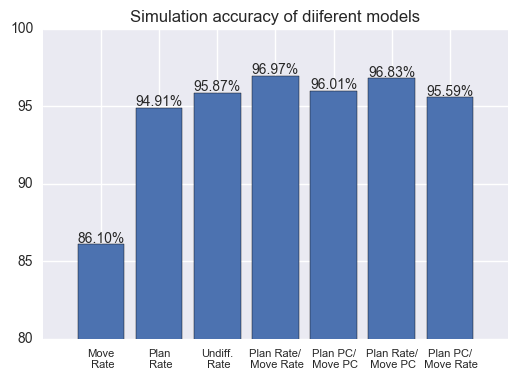

In [217]:
x=np.arange(len(results_accuracy))+1
plt.bar(left=x,height=np.array(results_accuracy)*100,align='center',tick_label=category)
plt.xticks(horizontalalignment='center',fontsize=8)
plt.ylim(80,100)
plt.title('Simulation accuracy of diiferent models')
for a,b in zip(x,np.array(results_accuracy)*100):
    c=str(b)[:5]+'%'
    plt.text(a,b+0.1,c,horizontalalignment='center')

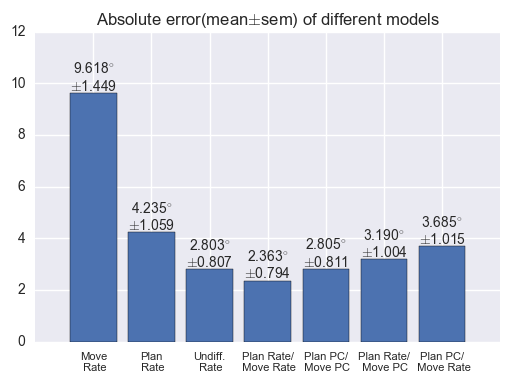

In [218]:
x=np.arange(len(results_accuracy))+1
plt.bar(left=x,height=results_degrees,align='center',tick_label=category)
plt.xticks(horizontalalignment='center',fontsize=8)
plt.ylim(0,12)
plt.title('Absolute error(mean$\pm$sem) of different models')
for a,b in zip(x,results_degrees):
    c=str(b)[:5]+'$^{\circ}$'+'\n''$\pm$'+str(results_sem[a-1])[:5]
    plt.text(a,b+0.1,c,horizontalalignment='center')

# End